# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP
from common_utils import CustomDataset
from common_utils import loss_fn
from common_utils import split_dataset, preprocess_dataset

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

X_train, y_train, X_test, y_test = split_dataset(df, ['filename', 'label'], 0.3, 0)

X_train

,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,melspectrogram_mean,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
11631,107.666016,2446,174.714286,0.581436,0.070376,0.455908,0.086070,0.255325,0.018142,0.024780,...,-5.770311,101.961494,0.726778,65.895195,-0.372497,59.756054,-2.990087,48.541611,-2.369126,74.494980
6619,117.453835,1919,147.615385,0.570992,0.068214,0.533140,0.067908,0.270572,0.010124,0.023933,...,-2.420724,72.575821,0.157023,89.650146,-3.008414,66.569794,-0.562329,61.818340,3.631580,86.445297
1257,135.999178,3866,193.300000,0.665871,0.064646,0.575811,0.055166,0.274959,0.007731,0.171105,...,-0.276058,79.474617,2.507980,64.289543,2.488033,57.481800,0.371860,56.641167,0.653117,58.880585
7611,103.359375,184,46.000000,0.581547,0.076387,0.457474,0.070914,0.260429,0.015510,0.116615,...,-3.115304,87.528542,-4.961778,104.891090,4.375006,73.968193,0.428776,61.100105,-1.731462,44.836227
4665,71.777344,261,65.250000,0.554061,0.081497,0.491283,0.079467,0.261753,0.014819,0.009013,...,-7.038899,53.558556,-2.577223,57.261269,-3.824014,46.565659,-6.141013,50.087326,-1.887392,59.745602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,143.554688,901,90.100000,0.478259,0.096148,0.438220,0.092903,0.259968,0.015750,0.065788,...,-10.744453,77.242554,-5.778560,78.063904,-3.756855,57.650112,-6.038925,56.642426,-6.883427,68.010582
3264,107.666016,11359,366.419355,0.528170,0.089229,0.514248,0.072142,0.270735,0.010036,0.002701,...,-10.639221,85.417351,1.240076,63.720001,2.164308,57.301521,-5.378757,62.188622,3.131972,60.999619
9845,103.359375,455,75.833333,0.564319,0.094585,0.384832,0.061052,0.249539,0.021064,0.015486,...,-1.354200,46.093472,2.588070,63.986980,4.225698,56.400631,-0.810466,73.712036,0.072680,76.151619
10799,103.359375,4591,241.631579,0.721832,0.041792,0.531015,0.067686,0.259324,0.016084,0.031883,...,-4.262617,65.467903,-0.299933,61.815067,8.531980,61.917839,-0.106459,49.114147,3.769001,52.739552


3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [3]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = {}, {}, {}, {}
    for batch_size in parameters:
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []
        for train_idx, test_idx in cv.split(X_train, y_train):
            x_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
            
            x_test_fold, y_test_fold = X_train[test_idx], y_train[test_idx]

            x_train_fold_scale, x_test_fold_scale = preprocess_dataset(x_train_fold, x_test_fold)
            
            X_train_scaled_dict[batch_size].append(x_train_fold_scale)
            X_val_scaled_dict[batch_size].append(x_test_fold_scale)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_test_fold)
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [128, 256, 512, 1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)

4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [4]:
# YOUR CODE HERE
from datetime import datetime
no_epochs = 100
from common_utils import EarlyStopper
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, hyperparameter):
    cross_validation_accuracies, cross_validation_times = [], []
    early_stopper = EarlyStopper(patience=3, min_delta=0)
    for batch_size in batch_sizes:
        print()
        print("Batch Size: " + str(batch_size))
        
        model = MLP(77,128,1)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        fold_acc = []
        fold_time = []
        for fold in range(5):
            train_data = CustomDataset(X_train_scaled_dict[batch_size][fold], y_train_dict[batch_size][fold])
            test_data = CustomDataset(X_val_scaled_dict[batch_size][fold], y_val_dict[batch_size][fold])
            train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
            epoch_acc = []
            for epoch in range(no_epochs):
                acc = 0
                start_time = datetime.now()
                model.train()
                for batch, (x_train,y_train) in enumerate(train_dataloader):
                    pred = model(x_train)
                    pred = pred.flatten()
                    loss = loss_fn(pred, y_train)

                    optimizer.zero_grad()
                    loss.backward() 
                    optimizer.step() 
                
                size = len(test_dataloader.dataset)
                correct = 0
                test_loss = 0
                model.eval()
                with torch.no_grad():
                    for batch,(x_test, y_test) in enumerate(test_dataloader):
                        pred = model(x_test)
                        pred = pred.flatten()
                        test_loss += loss_fn(pred,y_test).item()
                        correct += (pred.round() == y_test).type(torch.float).sum().item()
                        
                acc = correct/size

                test_loss /= size
                end_time = datetime.now()
                elapsed_time = end_time - start_time
                if early_stopper.early_stop(test_loss):
                    print("Done!")
                    fold_time.append(elapsed_time.microseconds/1000000)
                    fold_acc.append(acc)

                    break
                if epoch == no_epochs-1:
                    fold_time.append(elapsed_time.microseconds/1000000)
                    fold_acc.append(acc)

            print("fold " + str(fold) + ":" + str(acc))
        cross_validation_accuracies.append(np.mean(np.array(fold_acc), axis = 0))
        cross_validation_times.append(np.mean(np.array(fold_time), axis = 0))

    return cross_validation_accuracies, cross_validation_times
        

batch_sizes = [128, 256, 512, 1024]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')



Batch Size: 128
Done!
fold 0:0.7251184834123223
Done!
fold 1:0.8696682464454977
Done!
fold 2:0.8933649289099526
Done!
fold 3:0.9075829383886256
Done!
fold 4:0.9110847658565501

Batch Size: 256
Done!
fold 0:0.5639810426540285
Done!
fold 1:0.5746445497630331
Done!
fold 2:0.5983412322274881
Done!
fold 3:0.6161137440758294
Done!
fold 4:0.6520450503852994

Batch Size: 512
Done!
fold 0:0.5699052132701422
Done!
fold 1:0.5710900473933649
Done!
fold 2:0.6984597156398105
Done!
fold 3:0.7991706161137441
Done!
fold 4:0.8245406046235921

Batch Size: 1024
Done!
fold 0:0.7114928909952607
Done!
fold 1:0.8388625592417062
Done!
fold 2:0.8637440758293838
Done!
fold 3:0.8637440758293838
Done!
fold 4:0.8861885002963841


5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

Text(0, 0.5, 'cross-validation accuracy')

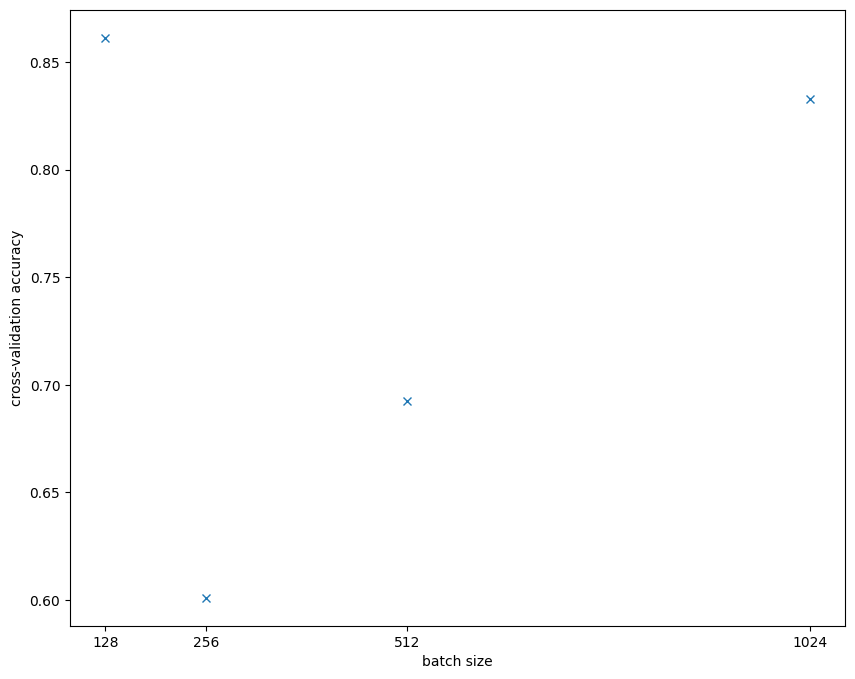

In [5]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(batch_sizes, cross_validation_accuracies, marker = 'x', linestyle = 'None')
plt.xticks(batch_sizes)
plt.xlabel('batch size')
plt.ylabel('cross-validation accuracy')

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [6]:
df = pd.DataFrame({'Batch Size': batch_sizes,
                   'Last Epoch Time':cross_validation_times})

df



,Batch Size,Last Epoch Time
0,128,0.149991
1,256,0.123725
2,512,0.117931
3,1024,0.099875


In [7]:
# YOUR CODE HERE
optimal_batch_size = 128
reason = "The mean cross validation accuracy is the highest for batch size 128. Even though the time taken for the last epoch for batch size 128 is the longest, the time saved for other batch size is too small to be significant. Hence 128 is the optimal batch size."